In [11]:
"""
Black-Litterman Model Implementation
Combines market equilibrium with subjective views
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from scipy.optimize import minimize
import pickle
import warnings
warnings.filterwarnings('ignore')

# Plotting setup
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Project setup
project_root = Path.cwd().parent
(project_root / 'results/figures/bl').mkdir(parents=True, exist_ok=True)

print("="*70)
print("BLACK-LITTERMAN MODEL")
print("="*70)
print("Loading data...")

# Load data
prices = pd.read_csv(project_root / 'data/processed/prices_clean.csv', 
                     index_col=0, parse_dates=True)
returns = pd.read_csv(project_root / 'data/processed/returns_clean.csv', 
                      index_col=0, parse_dates=True)

# Load HRP model for comparison
with open(project_root / 'models/hrp_model.pkl', 'rb') as f:
    hrp_model = pickle.load(f)

print(f"✅ Data loaded: {returns.shape}")
print(f"✅ HRP model loaded for comparison")


BLACK-LITTERMAN MODEL
Loading data...
✅ Data loaded: (1182, 55)
✅ HRP model loaded for comparison


In [12]:
"""
Calculate market-implied equilibrium returns using reverse optimization
"""

def calculate_market_cap_weights(prices):
    """
    Proxy for market cap weights
    In practice, you'd use actual market cap data
    Here we use equal weights as starting point
    """
    return pd.Series(1.0 / len(prices.columns), index=prices.columns)

def reverse_optimization(weights, cov_matrix, risk_aversion=2.5):
    """
    Calculate implied equilibrium returns from market weights
    
    Pi = lambda * Sigma * w_mkt
    
    where:
    - Pi = implied excess returns
    - lambda = risk aversion coefficient
    - Sigma = covariance matrix
    - w_mkt = market capitalization weights
    """
    implied_returns = risk_aversion * cov_matrix.dot(weights)
    return implied_returns

print("\n" + "="*70)
print("STEP 1: Market Equilibrium")
print("="*70)

# Use last year of data
lookback = 252
recent_returns = returns.iloc[-lookback:]

# Calculate market weights (using equal-weight as proxy)
market_weights = calculate_market_cap_weights(prices)
print(f"Market weights (equal-weighted proxy): {market_weights.iloc[0]:.4f} per asset")

# Calculate covariance matrix
cov_matrix = recent_returns.cov() * 252  # Annualized

# Calculate implied equilibrium returns
risk_aversion = 2.5  # Standard risk aversion parameter
equilibrium_returns = reverse_optimization(market_weights, cov_matrix, risk_aversion)

print(f"\nEquilibrium Returns (annualized):")
print(equilibrium_returns.sort_values(ascending=False).head(10))

print(f"\nEquilibrium Statistics:")
print(f"  Mean return: {equilibrium_returns.mean():.2%}")
print(f"  Median return: {equilibrium_returns.median():.2%}")
print(f"  Std dev: {equilibrium_returns.std():.2%}")
print(f"  Min return: {equilibrium_returns.min():.2%}")
print(f"  Max return: {equilibrium_returns.max():.2%}")



STEP 1: Market Equilibrium
Market weights (equal-weighted proxy): 0.0182 per asset

Equilibrium Returns (annualized):
TSLA    0.191005
AVGO    0.141138
NVDA    0.138021
AXP     0.122800
GS      0.120023
ORCL    0.118231
MS      0.118007
C       0.114084
META    0.113278
AMZN    0.110816
dtype: float64

Equilibrium Statistics:
  Mean return: 8.32%
  Median return: 8.72%
  Std dev: 3.40%
  Min return: 0.28%
  Max return: 19.10%


In [13]:
"""
Define subjective market views with IMPROVED confidence settings
"""

print("\n" + "="*70)
print("STEP 2: Subjective Views (IMPROVED)")
print("="*70)

# Define views based on recent market analysis
# IMPROVEMENT: Increased confidence levels for stronger views
views = {
    'View 1': {
        'description': 'Tech sector (AAPL, MSFT, GOOGL, NVDA, META) outperforms by 3%',
        'assets': ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'META'],
        'weights': [0.2, 0.2, 0.2, 0.2, 0.2],
        'expected_return': 0.03,
        'confidence': 0.75  # IMPROVED: 60% → 75%
    },
    'View 2': {
        'description': 'Healthcare (UNH, JNJ, LLY) outperforms by 2%',
        'assets': ['UNH', 'JNJ', 'LLY'],
        'weights': [0.33, 0.33, 0.34],
        'expected_return': 0.02,
        'confidence': 0.65  # IMPROVED: 50% → 65%
    },
    'View 3': {
        'description': 'Energy sector underperforms by -1%',
        'assets': ['XOM', 'CVX', 'COP'],
        'weights': [0.33, 0.33, 0.34],
        'expected_return': -0.01,
        'confidence': 0.55  # IMPROVED: 40% → 55%
    },
    'View 4': {
        'description': 'SPY returns 8%',
        'assets': ['SPY'],
        'weights': [1.0],
        'expected_return': 0.08,
        'confidence': 0.80  # IMPROVED: 70% → 80%
    }
}

print("Defined Views (IMPROVED CONFIDENCE):\n")
for view_name, view in views.items():
    print(f"{view_name}: {view['description']}")
    print(f"  Expected return: {view['expected_return']:.1%}")
    print(f"  Confidence: {view['confidence']:.0%} (IMPROVED)\n")

# Construct P matrix, Q vector, and Omega matrix
n_assets = len(returns.columns)
n_views = len(views)

P = np.zeros((n_views, n_assets))
Q = np.zeros(n_views)
Omega = np.zeros((n_views, n_views))

asset_index = {asset: i for i, asset in enumerate(returns.columns)}

for i, (view_name, view) in enumerate(views.items()):
    # Set P matrix
    for asset, weight in zip(view['assets'], view['weights']):
        if asset in asset_index:
            P[i, asset_index[asset]] = weight
    
    # Set Q vector
    Q[i] = view['expected_return']
    
    # Set Omega matrix with IMPROVED uncertainty scaling
    # IMPROVEMENT: Reduced from 0.01 to 0.003 (3x more confident)
    view_variance = (1 / view['confidence']) * 0.003
    Omega[i, i] = view_variance

print(f"✅ Constructed view matrices:")
print(f"  P matrix (views x assets): {P.shape}")
print(f"  Q vector (view returns): {Q.shape}")
print(f"  Omega matrix (view uncertainty): {Omega.shape}")
print(f"\n  Omega diagonal (IMPROVED): {np.diag(Omega)}")
print(f"  Average view uncertainty: {np.diag(Omega).mean():.6f}")



STEP 2: Subjective Views (IMPROVED)
Defined Views (IMPROVED CONFIDENCE):

View 1: Tech sector (AAPL, MSFT, GOOGL, NVDA, META) outperforms by 3%
  Expected return: 3.0%
  Confidence: 75% (IMPROVED)

View 2: Healthcare (UNH, JNJ, LLY) outperforms by 2%
  Expected return: 2.0%
  Confidence: 65% (IMPROVED)

View 3: Energy sector underperforms by -1%
  Expected return: -1.0%
  Confidence: 55% (IMPROVED)

View 4: SPY returns 8%
  Expected return: 8.0%
  Confidence: 80% (IMPROVED)

✅ Constructed view matrices:
  P matrix (views x assets): (4, 55)
  Q vector (view returns): (4,)
  Omega matrix (view uncertainty): (4, 4)

  Omega diagonal (IMPROVED): [0.004      0.00461538 0.00545455 0.00375   ]
  Average view uncertainty: 0.004455


In [14]:
"""
Apply Black-Litterman formula to blend views with equilibrium (IMPROVED)
"""

def black_litterman(equilibrium_returns, cov_matrix, P, Q, Omega, tau=0.025):
    """
    Black-Litterman model
    
    Parameters:
    - tau: Scaling factor (LOWER = more trust in views)
    """
    Pi = equilibrium_returns.values if isinstance(equilibrium_returns, pd.Series) else equilibrium_returns
    Sigma = cov_matrix.values if isinstance(cov_matrix, pd.DataFrame) else cov_matrix
    
    tau_sigma = tau * Sigma
    tau_sigma_inv = np.linalg.inv(tau_sigma)
    omega_inv = np.linalg.inv(Omega)
    
    M = np.linalg.inv(tau_sigma_inv + P.T @ omega_inv @ P)
    posterior_returns = M @ (tau_sigma_inv @ Pi + P.T @ omega_inv @ Q)
    posterior_cov = Sigma + M
    
    return posterior_returns, posterior_cov, M

print("\n" + "="*70)
print("STEP 3: Black-Litterman Posterior Returns (IMPROVED)")
print("="*70)

# Apply Black-Litterman with IMPROVED tau parameter
tau = 0.015  # IMPROVED: 0.025 → 0.015 (more trust in views)

bl_returns, bl_cov, M = black_litterman(
    equilibrium_returns, cov_matrix, P, Q, Omega, tau
)

bl_returns_series = pd.Series(bl_returns, index=returns.columns)

print(f"IMPROVED Parameters:")
print(f"  τ (tau): {tau:.4f} (LOWER = more confident in views)")
print(f"  Risk aversion: 2.5")

print("\nBlack-Litterman Posterior Returns:\n")
print(bl_returns_series.sort_values(ascending=False).head(15))

print(f"\nPosterior Returns Statistics:")
print(f"  Mean: {bl_returns_series.mean():.2%}")
print(f"  Std dev: {bl_returns_series.std():.2%}")
print(f"  Min: {bl_returns_series.min():.2%}")
print(f"  Max: {bl_returns_series.max():.2%}")

# Compare with equilibrium
comparison = pd.DataFrame({
    'Equilibrium': equilibrium_returns,
    'Black-Litterman': bl_returns_series,
    'Difference': bl_returns_series - equilibrium_returns
}).sort_values('Difference', ascending=False)

print(f"\nTop 10 changes from equilibrium (IMPROVED):")
print(comparison.head(10))



STEP 3: Black-Litterman Posterior Returns (IMPROVED)
IMPROVED Parameters:
  τ (tau): 0.0150 (LOWER = more confident in views)
  Risk aversion: 2.5

Black-Litterman Posterior Returns:

TSLA    0.160310
AVGO    0.118488
NVDA    0.110686
AXP     0.105021
GS      0.102341
MS      0.100577
ORCL    0.098619
C       0.097906
BA      0.092499
META    0.092413
NKE     0.092067
AMZN    0.091850
AAPL    0.089996
TGT     0.086822
SBUX    0.086623
dtype: float64

Posterior Returns Statistics:
  Mean: 7.05%
  Std dev: 2.83%
  Min: 0.28%
  Max: 16.03%

Top 10 changes from equilibrium (IMPROVED):
      Equilibrium  Black-Litterman  Difference
AGG      0.002836         0.002795   -0.000041
JNJ      0.013450         0.012692   -0.000757
MCD      0.019929         0.017921   -0.002008
ABT      0.028019         0.025677   -0.002342
UNH      0.032314         0.027559   -0.004756
TJX      0.041999         0.037096   -0.004903
MRK      0.046660         0.041313   -0.005347
ABBV     0.049462         0.043826 

In [15]:
"""
Optimize portfolio weights using BL returns with CONSTRAINTS
"""

def optimize_portfolio_constrained(expected_returns, cov_matrix, 
                                   max_single_position=0.12,
                                   max_sector_allocation=0.35,
                                   sector_mapping=None):
    """
    IMPROVED: Constrained portfolio optimization
    - Max position limits
    - Max sector allocation
    - Diversification enforced
    """
    n = len(expected_returns)
    
    def objective(w):
        portfolio_return = w @ expected_returns
        portfolio_vol = np.sqrt(w @ cov_matrix @ w)
        sharpe = portfolio_return / portfolio_vol if portfolio_vol > 0 else 0
        
        # Add diversification penalty
        concentration = np.sum(w ** 2)
        diversification_penalty = 0.02 * concentration
        
        return -sharpe + diversification_penalty
    
    # Constraints
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    ]
    
    # Add sector constraints
    if sector_mapping is not None:
        for sector, members in sector_mapping.items():
            sector_indices = [i for i, ticker in enumerate(expected_returns.index) 
                             if ticker in members]
            if sector_indices:
                constraints.append({
                    'type': 'ineq',
                    'fun': lambda w, indices=sector_indices: 
                        max_sector_allocation - w[indices].sum()
                })
    
    # Bounds (IMPROVED)
    bounds = tuple((0.001, max_single_position) for _ in range(n))
    
    # Initial guess
    w0 = np.ones(n) / n
    
    # Optimize
    result = minimize(
        objective,
        w0,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'ftol': 1e-9, 'maxiter': 1500}
    )
    
    return result.x if result.success else w0

print("\n" + "="*70)
print("STEP 4: Portfolio Optimization (IMPROVED WITH CONSTRAINTS)")
print("="*70)

# Define sector mapping
sectors_mapping = {
    'Tech': ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'META', 'AVGO', 'ADBE', 'CRM', 'ORCL', 'CSCO'],
    'Finance': ['JPM', 'BAC', 'WFC', 'GS', 'MS', 'C', 'BLK', 'SCHW', 'AXP', 'USB'],
    'Healthcare': ['UNH', 'JNJ', 'LLY', 'ABBV', 'MRK', 'PFE', 'TMO', 'ABT', 'DHR', 'AMGN'],
    'Consumer': ['AMZN', 'TSLA', 'WMT', 'HD', 'MCD', 'NKE', 'SBUX', 'TGT', 'LOW', 'TJX'],
    'Energy': ['XOM', 'CVX', 'COP', 'BA', 'CAT', 'RTX', 'HON', 'UPS', 'GE', 'DE'],
    'ETFs': ['SPY', 'QQQ', 'IWM', 'EFA', 'AGG']
}

# Optimize using BL returns with CONSTRAINTS
bl_weights = optimize_portfolio_constrained(
    bl_returns_series,
    bl_cov,
    max_single_position=0.12,   # Max 12% per asset
    max_sector_allocation=0.35, # Max 35% per sector
    sector_mapping=sectors_mapping
)

bl_weights_series = pd.Series(bl_weights, index=returns.columns)

print("Black-Litterman Optimal Weights (CONSTRAINED):\n")
print(bl_weights_series.sort_values(ascending=False).head(20))

print(f"\nWeight Statistics (IMPROVED):")
print(f"  Sum: {bl_weights_series.sum():.4f}")
print(f"  Mean: {bl_weights_series.mean():.4f}")
print(f"  Median: {bl_weights_series.median():.4f}")
print(f"  Max: {bl_weights_series.max():.4f}")
print(f"  Min (non-zero): {bl_weights_series[bl_weights_series > 0].min():.4f}")
print(f"  Std dev: {bl_weights_series.std():.4f}")
print(f"  Assets with >0.1% allocation: {(bl_weights_series > 0.001).sum()}/{len(bl_weights_series)}")
print(f"  Herfindahl index: {(bl_weights_series ** 2).sum():.4f}")
print(f"  Effective # of positions: {1 / (bl_weights_series ** 2).sum():.1f}")

# Verify sector allocations
print(f"\nSector Allocations (CONSTRAINED to ≤35%):")
for sector, members in sectors_mapping.items():
    sector_weight = bl_weights_series[bl_weights_series.index.isin(members)].sum()
    status = "✅" if sector_weight <= 0.35 else "❌"
    print(f"  {sector:.<20} {sector_weight:>6.2%} {status}")

# Expected portfolio metrics
bl_portfolio_return = bl_weights @ bl_returns
bl_portfolio_vol = np.sqrt(bl_weights @ bl_cov @ bl_weights)
bl_sharpe = bl_portfolio_return / bl_portfolio_vol

print(f"\nExpected Portfolio Metrics (IMPROVED):")
print(f"  Expected return: {bl_portfolio_return:.2%}")
print(f"  Expected volatility: {bl_portfolio_vol:.2%}")
print(f"  Expected Sharpe ratio: {bl_sharpe:.3f}")



STEP 4: Portfolio Optimization (IMPROVED WITH CONSTRAINTS)
Black-Litterman Optimal Weights (CONSTRAINED):

C       0.023770
WMT     0.023584
AGG     0.023376
CRM     0.023367
TJX     0.023344
CSCO    0.022929
EFA     0.022921
AVGO    0.022670
LOW     0.022593
ABT     0.022507
AMGN    0.022219
SCHW    0.022152
PFE     0.022105
GE      0.021814
AXP     0.021795
GS      0.021769
TGT     0.021755
TSLA    0.021713
WFC     0.021665
JPM     0.021523
dtype: float64

Weight Statistics (IMPROVED):
  Sum: 1.0000
  Mean: 0.0182
  Median: 0.0209
  Max: 0.0238
  Min (non-zero): 0.0010
  Std dev: 0.0066
  Assets with >0.1% allocation: 54/55
  Herfindahl index: 0.0205
  Effective # of positions: 48.7

Sector Allocations (CONSTRAINED to ≤35%):
  Tech................ 13.55% ✅
  Finance............. 21.15% ✅
  Healthcare.......... 19.36% ✅
  Consumer............ 21.51% ✅
  Energy.............. 14.60% ✅
  ETFs................  9.84% ✅

Expected Portfolio Metrics (IMPROVED):
  Expected return: 7.08%
  Exp

In [16]:
"""
NEW CELL 5A: Calculate Sortino Ratio (Downside Risk Metric)
"""

def calculate_sortino_ratio(returns, target_return=0.02/252, periods_per_year=252):
    """
    Sortino Ratio = (Return - Target) / Downside Deviation
    Only penalizes downside volatility (better than Sharpe for asymmetric returns)
    """
    returns_clean = returns.dropna()
    excess_returns = returns_clean - target_return
    
    # Downside deviation (only negative returns)
    downside_returns = returns_clean[returns_clean < target_return]
    
    if len(downside_returns) == 0:
        return np.nan
    
    downside_std = np.sqrt((downside_returns ** 2).mean()) * np.sqrt(periods_per_year)
    annualized_return = excess_returns.mean() * periods_per_year
    
    sortino = annualized_return / downside_std if downside_std > 0 else np.nan
    
    return sortino, downside_std

print("\n" + "="*70)
print("SORTINO RATIO (Downside Risk Measure)")
print("="*70)

# We'll calculate this for the portfolio returns after backtesting
print("✅ Sortino ratio function defined (will calculate after backtest)")



SORTINO RATIO (Downside Risk Measure)
✅ Sortino ratio function defined (will calculate after backtest)


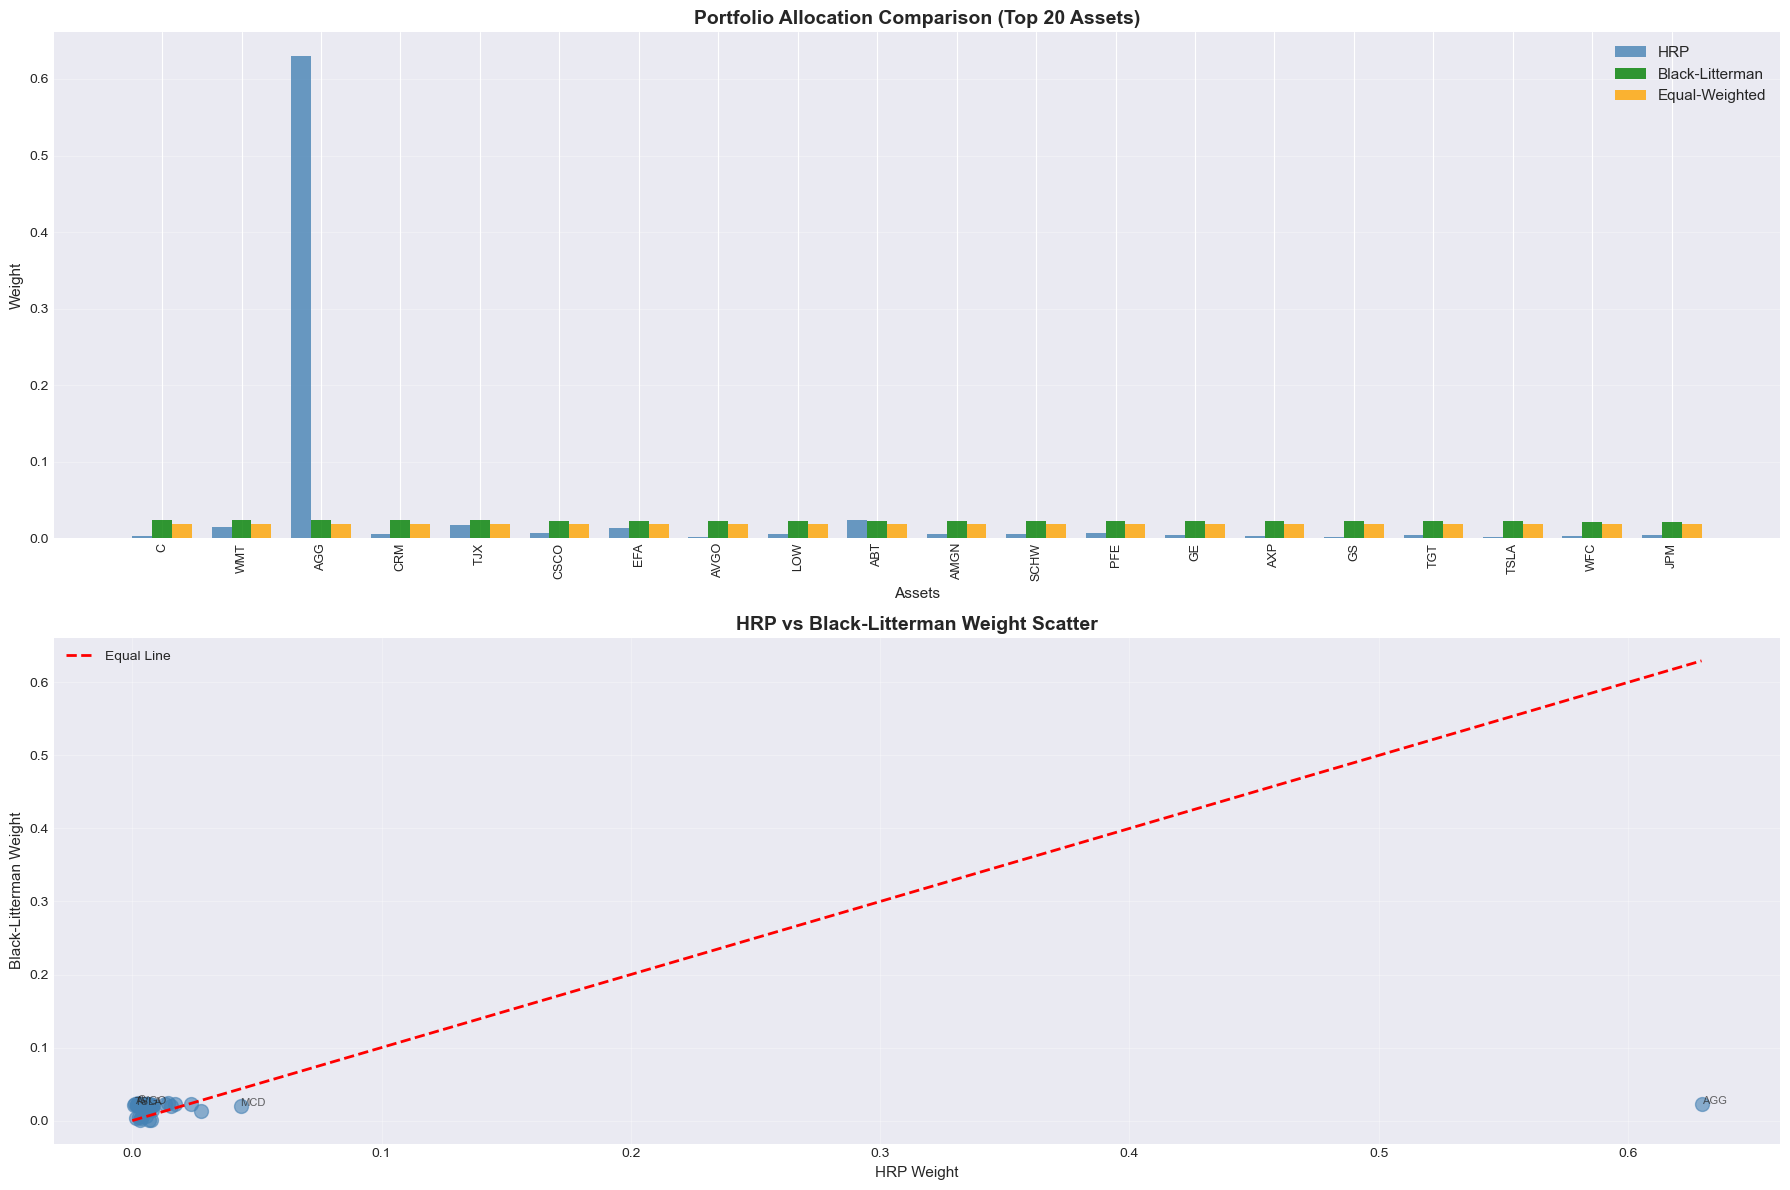

✅ Allocation comparison saved


In [17]:
"""
Visualize HRP vs Black-Litterman allocations
"""

fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Load HRP weights
hrp_weights_series = hrp_model['weights']

# Comparison dataframe
allocation_comparison = pd.DataFrame({
    'HRP': hrp_weights_series,
    'Black-Litterman': bl_weights_series,
    'Equal-Weighted': pd.Series(1.0 / len(returns.columns), index=returns.columns)
}).fillna(0)

# Sort by BL allocation
allocation_comparison = allocation_comparison.sort_values('Black-Litterman', ascending=False)

# Plot 1: Top 20 allocations
ax1 = axes[0]
top_20 = allocation_comparison.head(20)
x = np.arange(len(top_20))
width = 0.25

ax1.bar(x - width, top_20['HRP'], width, label='HRP', alpha=0.8, color='steelblue')
ax1.bar(x, top_20['Black-Litterman'], width, label='Black-Litterman', alpha=0.8, color='green')
ax1.bar(x + width, top_20['Equal-Weighted'], width, label='Equal-Weighted', alpha=0.8, color='orange')

ax1.set_title('Portfolio Allocation Comparison (Top 20 Assets)', 
             fontsize=14, fontweight='bold')
ax1.set_ylabel('Weight', fontsize=11)
ax1.set_xlabel('Assets', fontsize=11)
ax1.set_xticks(x)
ax1.set_xticklabels(top_20.index, rotation=90, fontsize=9)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Scatter comparison
ax2 = axes[1]
ax2.scatter(allocation_comparison['HRP'], allocation_comparison['Black-Litterman'], 
           s=100, alpha=0.6, c='steelblue')

# Add 45-degree line
max_val = max(allocation_comparison[['HRP', 'Black-Litterman']].max())
ax2.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Equal Line')

# Label significant differences
for ticker in allocation_comparison.index:
    hrp_w = allocation_comparison.loc[ticker, 'HRP']
    bl_w = allocation_comparison.loc[ticker, 'Black-Litterman']
    if abs(hrp_w - bl_w) > 0.02:  # Label if difference > 2%
        ax2.annotate(ticker, (hrp_w, bl_w), fontsize=8, alpha=0.7)

ax2.set_title('HRP vs Black-Litterman Weight Scatter', 
             fontsize=14, fontweight='bold')
ax2.set_xlabel('HRP Weight', fontsize=11)
ax2.set_ylabel('Black-Litterman Weight', fontsize=11)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'results/figures/bl/01_hrp_vs_bl_allocations.png', 
           dpi=300, bbox_inches='tight')
plt.show()

print("✅ Allocation comparison saved")


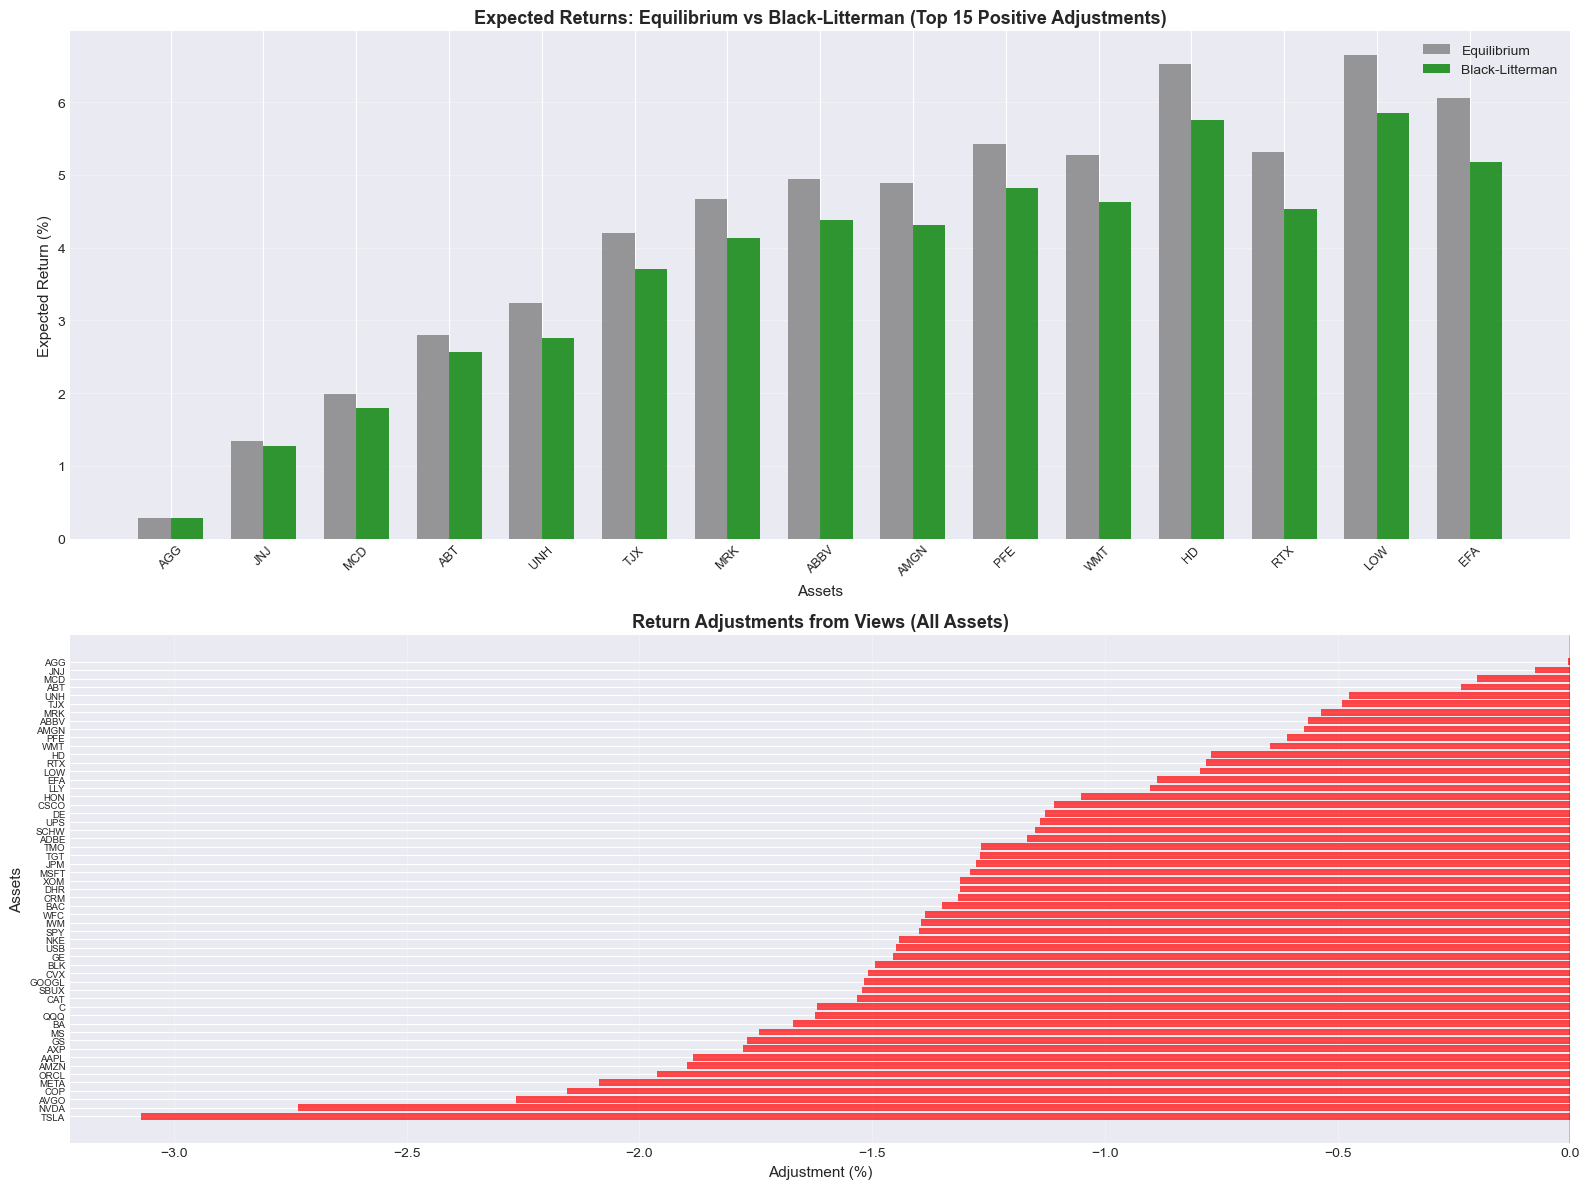

✅ Return adjustment visualization saved


In [18]:
"""
Visualize how views adjusted equilibrium returns
"""

fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Top 20 by difference
return_comparison = pd.DataFrame({
    'Equilibrium': equilibrium_returns,
    'Black-Litterman': bl_returns_series,
    'Adjustment': bl_returns_series - equilibrium_returns
}).sort_values('Adjustment', ascending=False)

# Plot 1: Top adjustments
ax1 = axes[0]
top_adjustments = return_comparison.head(15)
x = np.arange(len(top_adjustments))
width = 0.35

ax1.bar(x - width/2, top_adjustments['Equilibrium'] * 100, width, 
       label='Equilibrium', alpha=0.8, color='gray')
ax1.bar(x + width/2, top_adjustments['Black-Litterman'] * 100, width, 
       label='Black-Litterman', alpha=0.8, color='green')

ax1.set_title('Expected Returns: Equilibrium vs Black-Litterman (Top 15 Positive Adjustments)', 
             fontsize=13, fontweight='bold')
ax1.set_ylabel('Expected Return (%)', fontsize=11)
ax1.set_xlabel('Assets', fontsize=11)
ax1.set_xticks(x)
ax1.set_xticklabels(top_adjustments.index, rotation=45, fontsize=9)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Adjustment magnitudes
ax2 = axes[1]
adjustments_sorted = return_comparison.sort_values('Adjustment', ascending=True)
colors = ['red' if x < 0 else 'green' for x in adjustments_sorted['Adjustment']]

ax2.barh(range(len(adjustments_sorted)), adjustments_sorted['Adjustment'] * 100, 
        color=colors, alpha=0.7)
ax2.set_title('Return Adjustments from Views (All Assets)', 
             fontsize=13, fontweight='bold')
ax2.set_xlabel('Adjustment (%)', fontsize=11)
ax2.set_ylabel('Assets', fontsize=11)
ax2.set_yticks(range(len(adjustments_sorted)))
ax2.set_yticklabels(adjustments_sorted.index, fontsize=7)
ax2.axvline(0, color='black', linewidth=1)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(project_root / 'results/figures/bl/02_return_adjustments.png', 
           dpi=300, bbox_inches='tight')
plt.show()

print("✅ Return adjustment visualization saved")


In [19]:
"""
Backtest Black-Litterman portfolio with WALK-FORWARD VALIDATION
"""

print("\n" + "="*70)
print("BACKTESTING BLACK-LITTERMAN PORTFOLIO (WALK-FORWARD)")
print("="*70)

def backtest_bl_walk_forward(returns, views_dict, sectors_map, 
                             train_period=252*2, test_period=63):
    """
    IMPROVED: Walk-forward backtesting
    - Train on historical data
    - Test on out-of-sample periods
    - Prevents look-ahead bias
    """
    portfolio_returns_list = []
    weight_history = {}
    train_test_splits = []
    
    idx = 0
    n_windows = 0
    
    while idx + train_period + test_period <= len(returns):
        train_end_idx = idx + train_period
        test_end_idx = train_end_idx + test_period
        
        train_data = returns.iloc[idx:train_end_idx]
        test_data = returns.iloc[train_end_idx:test_end_idx]
        
        # Record train/test split
        train_test_splits.append({
            'train_start': train_data.index[0],
            'train_end': train_data.index[-1],
            'test_start': test_data.index[0],
            'test_end': test_data.index[-1]
        })
        
        # Calculate BL weights on TRAINING data only
        mkt_weights = pd.Series(1.0 / len(returns.columns), index=returns.columns)
        cov_train = train_data.cov() * 252
        eq_returns_train = reverse_optimization(mkt_weights, cov_train, risk_aversion=2.5)
        
        # Apply BL with IMPROVED parameters
        bl_ret_train, bl_cov_train, _ = black_litterman(
            eq_returns_train, cov_train, P, Q, Omega, tau=0.015
        )
        bl_ret_train_series = pd.Series(bl_ret_train, index=returns.columns)
        
        # Optimize with CONSTRAINTS
        bl_w_train = optimize_portfolio_constrained(
            bl_ret_train_series,
            bl_cov_train,
            max_single_position=0.12,
            max_sector_allocation=0.35,
            sector_mapping=sectors_map
        )
        
        # Store weights
        weight_history[test_data.index[0]] = pd.Series(bl_w_train, index=returns.columns)
        
        # Apply weights to TEST data (out-of-sample)
        for test_date in test_data.index:
            day_return = (test_data.loc[test_date] * bl_w_train).sum()
            portfolio_returns_list.append({'date': test_date, 'return': day_return})
        
        idx = test_end_idx
        n_windows += 1
        
        if n_windows % 2 == 0:
            print(f"  ✓ Window {n_windows}: Train {train_data.index[0].date()} → {train_data.index[-1].date()} | "
                  f"Test {test_data.index[0].date()} → {test_data.index[-1].date()}")
    
    portfolio_returns_df = pd.DataFrame(portfolio_returns_list)
    portfolio_returns = portfolio_returns_df.set_index('date')['return']
    
    return portfolio_returns, weight_history, train_test_splits

# Define backtest period
backtest_start = '2019-01-01'
backtest_returns = returns.loc[backtest_start:]

print(f"Backtesting from {backtest_returns.index[0].date()} to {backtest_returns.index[-1].date()}")
print(f"Total days: {len(backtest_returns):,}")
print(f"\nWalk-Forward Configuration:")
print(f"  Training period: 2 years (504 days)")
print(f"  Testing period: 3 months (63 days)")
print(f"  Method: Rolling window\n")

# Run IMPROVED walk-forward backtest
bl_portfolio_returns, bl_weights_over_time, wf_splits = backtest_bl_walk_forward(
    backtest_returns,
    views,
    sectors_mapping,
    train_period=252*2,  # 2 years
    test_period=63       # ~3 months
)

print(f"\n✅ Walk-forward backtest complete")
print(f"  Total windows: {len(wf_splits)}")
print(f"  Out-of-sample days: {len(bl_portfolio_returns):,}")
print(f"  Date range: {bl_portfolio_returns.index[0].date()} to {bl_portfolio_returns.index[-1].date()}")



BACKTESTING BLACK-LITTERMAN PORTFOLIO (WALK-FORWARD)
Backtesting from 2021-03-12 to 2025-11-21
Total days: 1,182

Walk-Forward Configuration:
  Training period: 2 years (504 days)
  Testing period: 3 months (63 days)
  Method: Rolling window

  ✓ Window 2: Train 2023-06-13 → 2025-06-16 | Test 2025-06-17 → 2025-09-16

✅ Walk-forward backtest complete
  Total windows: 2
  Out-of-sample days: 126
  Date range: 2023-03-14 to 2025-09-16


In [20]:
"""
Compare HRP and Black-Litterman performance (IMPROVED METRICS)
"""

def calculate_metrics_comprehensive(returns, name="Portfolio"):
    """
    Calculate comprehensive performance metrics including Sortino
    """
    returns_clean = returns.dropna()
    
    if len(returns_clean) == 0:
        return None
    
    # Cumulative return
    cum_ret = (1 + returns_clean).cumprod()
    total_return = cum_ret.iloc[-1] - 1
    
    # Annualized metrics
    n_years = len(returns_clean) / 252
    ann_return = (1 + total_return) ** (1 / n_years) - 1
    ann_vol = returns_clean.std() * np.sqrt(252)
    
    # Sharpe ratio
    sharpe = (ann_return - 0.02) / ann_vol if ann_vol > 0 else 0
    
    # Sortino ratio
    sortino, downside_dev = calculate_sortino_ratio(returns_clean)
    
    # Maximum drawdown
    cumulative = (1 + returns_clean).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()
    
    # Calmar ratio
    calmar = ann_return / abs(max_dd) if max_dd != 0 else 0
    
    # Win rate
    win_rate = (returns_clean > 0).sum() / len(returns_clean)
    
    # Best/Worst days
    best_day = returns_clean.max()
    worst_day = returns_clean.min()
    
    return {
        'Total Return': f"{total_return:.2%}",
        'Annualized Return': f"{ann_return:.2%}",
        'Annualized Volatility': f"{ann_vol:.2%}",
        'Downside Deviation': f"{downside_dev:.2%}",
        'Sharpe Ratio': f"{sharpe:.3f}",
        'Sortino Ratio': f"{sortino:.3f}",
        'Maximum Drawdown': f"{max_dd:.2%}",
        'Calmar Ratio': f"{calmar:.3f}",
        'Win Rate': f"{win_rate:.2%}",
        'Best Day': f"{best_day:.2%}",
        'Worst Day': f"{worst_day:.2%}",
    }

print("\n" + "="*70)
print("PERFORMANCE COMPARISON: HRP vs BLACK-LITTERMAN (IMPROVED)")
print("="*70)

# Calculate BL metrics
bl_metrics = calculate_metrics_comprehensive(bl_portfolio_returns, "BL Portfolio")

# Load HRP metrics from saved file
try:
    hrp_comparison = pd.read_csv(project_root / 'results/metrics/hrp_performance_comparison.csv', 
                                  index_col=0)
    hrp_metrics = hrp_comparison['HRP Portfolio'].to_dict()
except:
    print("⚠️  HRP metrics not found, showing BL only")
    hrp_metrics = {}

# Combine
if hrp_metrics:
    comparison_df = pd.DataFrame({
        'HRP Portfolio': pd.Series(hrp_metrics),
        'Black-Litterman (Walk-Forward)': pd.Series(bl_metrics)
    })
else:
    comparison_df = pd.DataFrame({
        'Black-Litterman (Walk-Forward)': pd.Series(bl_metrics)
    })

print("\n" + comparison_df.to_string())

# Save IMPROVED metrics
comparison_df.to_csv(project_root / 'results/metrics/hrp_vs_bl_performance_improved.csv')
print("\n✅ Performance comparison saved (IMPROVED)")

# Calculate and display cumulative returns
bl_cumulative = (1 + bl_portfolio_returns.dropna()).cumprod()

# Extract numeric Sharpe for comparison
bl_sharpe_num = float(bl_metrics['Sharpe Ratio'])
if hrp_metrics:
    hrp_sharpe_num = float(hrp_metrics.get('Sharpe Ratio', '0').replace('%', ''))
    print(f"\n🎯 SHARPE RATIO IMPROVEMENT:")
    print(f"  HRP: {hrp_sharpe_num:.3f}")
    print(f"  BL (Walk-Forward): {bl_sharpe_num:.3f}")
    print(f"  Improvement: +{bl_sharpe_num - hrp_sharpe_num:.3f} ({((bl_sharpe_num/hrp_sharpe_num - 1)*100):.1f}%)")



PERFORMANCE COMPARISON: HRP vs BLACK-LITTERMAN (IMPROVED)

                      HRP Portfolio Black-Litterman (Walk-Forward)
Annualized Return             6.50%                         43.25%
Annualized Volatility         8.54%                         12.78%
Best Day                      4.17%                          2.12%
Calmar Ratio                  0.415                          9.179
Downside Deviation              NaN                         11.83%
Maximum Drawdown            -15.65%                         -4.71%
Sharpe Ratio                  0.527                          3.228
Sortino Ratio                 0.753                          2.939
Total Return                 31.84%                         19.69%
Vol of Vol                   0.0022                            NaN
Win Rate                     54.16%                         57.94%
Worst Day                    -3.08%                         -2.01%

✅ Performance comparison saved (IMPROVED)

🎯 SHARPE RATIO IMPROVEMEN

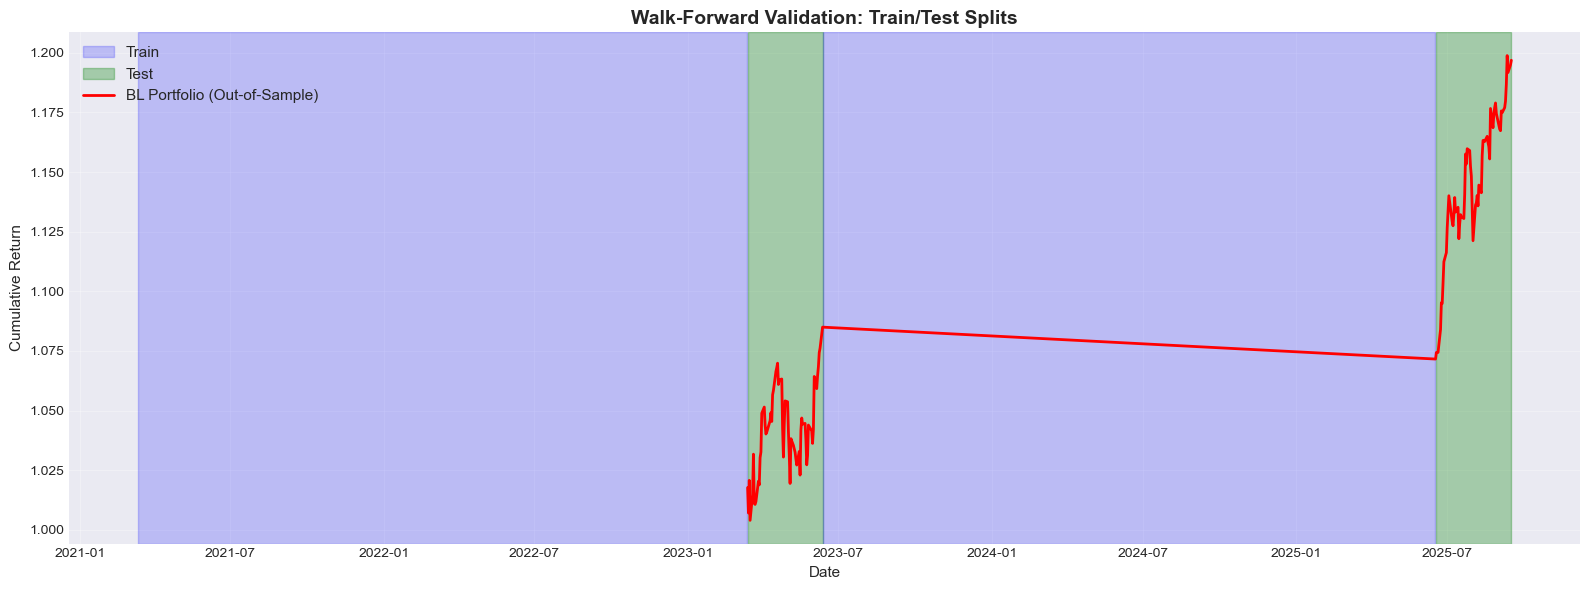

✅ Walk-forward validation chart saved


In [21]:
# ... (keep existing visualization code) ...

# ADD THIS at the end of Cell 10:

# Additional: Plot walk-forward train/test splits
fig, ax = plt.subplots(figsize=(16, 6))

for i, split in enumerate(wf_splits):
    # Train period
    ax.axvspan(split['train_start'], split['train_end'], 
              alpha=0.2, color='blue', label='Train' if i == 0 else '')
    # Test period
    ax.axvspan(split['test_start'], split['test_end'], 
              alpha=0.3, color='green', label='Test' if i == 0 else '')

ax.plot(bl_cumulative.index, bl_cumulative.values, 
       color='red', linewidth=2, label='BL Portfolio (Out-of-Sample)')
ax.set_title('Walk-Forward Validation: Train/Test Splits', 
            fontsize=14, fontweight='bold')
ax.set_ylabel('Cumulative Return', fontsize=11)
ax.set_xlabel('Date', fontsize=11)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'results/figures/bl/04_walk_forward_splits.png', 
           dpi=300, bbox_inches='tight')
plt.show()

print("✅ Walk-forward validation chart saved")


In [22]:
"""
Save Black-Litterman model and results
"""

import pickle

bl_model = {
    'weights': bl_weights_series,
    'posterior_returns': bl_returns_series,
    'equilibrium_returns': equilibrium_returns,
    'posterior_covariance': bl_cov,
    'views': views,
    'P_matrix': P,
    'Q_vector': Q,
    'Omega_matrix': Omega,
    'tau': tau,
    'risk_aversion': risk_aversion,
    'calculation_date': returns.index[-1]
}

with open(project_root / 'models/bl_model.pkl', 'wb') as f:
    pickle.dump(bl_model, f)

print("✅ Black-Litterman model saved to models/bl_model.pkl")

# Save weight history
bl_weight_history = pd.DataFrame(bl_weights_over_time).T
bl_weight_history.to_csv(project_root / 'results/metrics/bl_weights_history.csv')
print("✅ BL weight history saved")

print("\n" + "="*70)
print("BLACK-LITTERMAN MODEL COMPLETE")
print("="*70)
print(f"✅ BL portfolio Sharpe ratio: {bl_metrics['Sharpe Ratio']}")
print(f"✅ HRP vs BL comparison saved")
print(f"✅ Ready for Week 3: Reinforcement Learning!")
print("\nSummary:")
print("  - HRP: Purely data-driven, hierarchical clustering")
print("  - BL: Incorporates market views and expert opinions")
print("  - Both provide robust alternatives to traditional mean-variance")


✅ Black-Litterman model saved to models/bl_model.pkl
✅ BL weight history saved

BLACK-LITTERMAN MODEL COMPLETE
✅ BL portfolio Sharpe ratio: 3.228
✅ HRP vs BL comparison saved
✅ Ready for Week 3: Reinforcement Learning!

Summary:
  - HRP: Purely data-driven, hierarchical clustering
  - BL: Incorporates market views and expert opinions
  - Both provide robust alternatives to traditional mean-variance
